# Pattern Recognition

This notebook performs pattern recognition analysis on the cleaned SPY and options datasets from March 11–15, 2024. The goal is to identify notable behaviors in the data, including short-term trends, volume and trade-size spikes, and any unusual trading activity that does not follow the general flow.



**Pathing**


In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

def to_dt(s):
    return pd.to_datetime(s)

def plot_trends(df, name, log_activity=True):
    t = "datetime_et"
    if t not in df.columns:
        return
    keep = [c for c in [t,"price","close","volume","transactions"] if c in df.columns]
    d = df[keep].dropna(subset=[t]).copy()
    d[t] = to_dt(d[t]); d.sort_values(t, inplace=True)

    for c in ["price","close"]:
        if c in d.columns:
            y = pd.to_numeric(d[c], errors="coerce")
            fig, ax = plt.subplots()
            ax.plot(d[t], y)
            ax.set_title(f"{name}: {c} over time"); ax.set_xlabel(t); ax.set_ylabel(c)
            ax.tick_params(axis='x', rotation=45); fig.tight_layout(); plt.show()
            r = y.pct_change(); vol = r.rolling(60).std().mean()
            if pd.notna(vol): print(f"{name}: avg 60-step rolling volatility (pct std) ≈ {vol:.4f}")
            break

    for c in ["volume","transactions"]:
        if c in d.columns:
            y = pd.to_numeric(d[c], errors="coerce")
            if log_activity: y, lab = np.log1p(y), f"log1p({c})"
            else: lab = c
            fig, ax = plt.subplots()
            ax.plot(d[t], y)
            ax.set_title(f"{name}: {lab} over time"); ax.set_xlabel(t); ax.set_ylabel(lab)
            ax.tick_params(axis='x', rotation=45); fig.tight_layout(); plt.show()
            break

def plot_outliers(df, name, log_view=True, cap_q=0.99):
    cols = [c for c in ["size","volume","transactions"] if c in df.columns][:2]
    for c in cols:
        x = pd.to_numeric(df[c], errors="coerce").dropna()
        if x.empty:
            continue
        q1, q3 = x.quantile([0.25, 0.75]); iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        n_out = int(((x < lower) | (x > upper)).sum())
        print(f"{name}: outliers in {c} (IQR) = {n_out}")

        xp = x.clip(upper=x.quantile(cap_q)) if cap_q else x
        lab = f"log1p({c})" if log_view else c
        data = np.log1p(xp) if log_view else xp
        fig, ax = plt.subplots()
        ax.boxplot(data, vert=True)
        ax.set_title(f"{name}: boxplot of {lab}"); ax.set_ylabel(lab)
        fig.tight_layout(); plt.show()

def plot_cluster_view(df, name, log_y=True):
    for xc, yc in [("price","size"), ("close","volume"), ("close","transactions")]:
        if xc in df.columns and yc in df.columns:
            p = df[[xc, yc]].dropna().copy()
            y = pd.to_numeric(p[yc], errors="coerce")
            if log_y and yc in ("size","volume","transactions"):
                y, yl = np.log1p(y), f"log1p({yc})"
            else:
                yl = yc
            fig, ax = plt.subplots()
            ax.scatter(p[xc], y, s=6, alpha=0.4)
            ax.set_title(f"{name}: {yl} vs {xc}"); ax.set_xlabel(xc); ax.set_ylabel(yl)
            fig.tight_layout(); plt.show()
            break

def plot_time_gaps(df, name, min_gap_s=120):
    t = "datetime_et"
    if t not in df.columns:
        return
    d = df[[t]].dropna().copy()
    d[t] = to_dt(d[t]); d.sort_values(t, inplace=True)
    wk = d[t].dt.weekday < 5
    tm = d[t].dt.time
    mask = wk & (tm >= pd.to_datetime("09:30").time()) & (tm <= pd.to_datetime("16:00").time())
    d2 = d[mask].copy()
    g = d2.groupby(d2[t].dt.date)[t].diff().dt.total_seconds()
    g = g[g >= min_gap_s].dropna()
    if g.empty:
        return
    fig, ax = plt.subplots()
    ax.hist(g, bins=40)
    ax.set_title(f"{name}: intraday gaps ≥ {min_gap_s}s"); ax.set_xlabel("seconds"); ax.set_ylabel("count")
    fig.tight_layout(); plt.show()
    top_idx = g.nlargest(3).index
    print(f"{name}: largest intraday gaps (s) ≥ {min_gap_s}")
    for ts, val in zip(d2.loc[top_idx, t], g.loc[top_idx]):
        print(f"{ts}  {val:.0f}")

def run_pattern_recognition(df, name):
    print(f"\n=== {name}: Pattern Recognition ===")
    plot_trends(df, name, log_activity=True)
    plot_outliers(df, name, log_view=True, cap_q=0.99)
    plot_cluster_view(df, name, log_y=True)
    plot_time_gaps(df, name, min_gap_s=120)

**Pathing**

In [12]:
paths = {
    "SPY_trades": "../data/SPY_trades_clean_2024-03-11_2024-03-15.csv",
    "SPY_1s": "../data/SPY_1s_clean_2024-03-11_2024-03-15.csv",
    "SPY_1m": "../data/SPY_1m_clean_2024-03-11_2024-03-15.csv",
    "OPT_trades": "../data/OPT_trades_clean_2024-03-11_2024-03-15.csv",
    "OPT_1s": "../data/OPT_1s_clean_2024-03-11_2024-03-15.csv",
    "OPT_1m": "../data/OPT_1m_clean_2024-03-11_2024-03-15.csv",
}

dfs_pat = {name: pd.read_csv(p) for name,p in paths.items()}

## Pattern Recognition


=== SPY_trades: Pattern Recognition ===


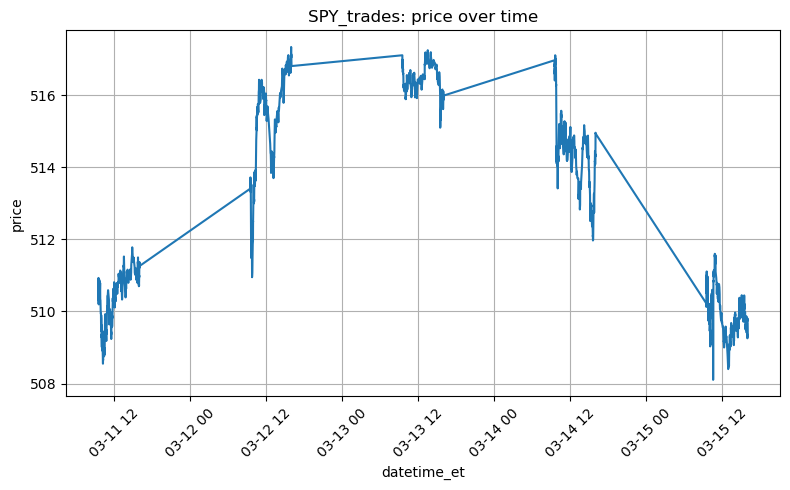

SPY_trades: avg 60-step rolling volatility (pct std) ≈ 0.0002
SPY_trades: outliers in size (IQR) = 255


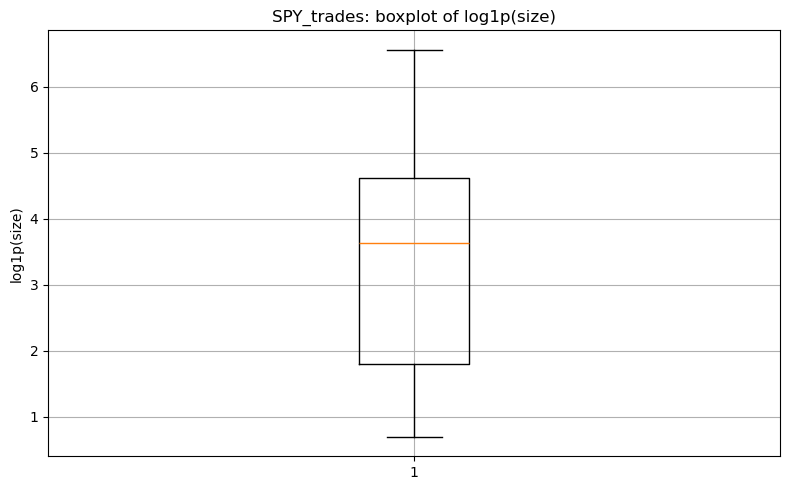

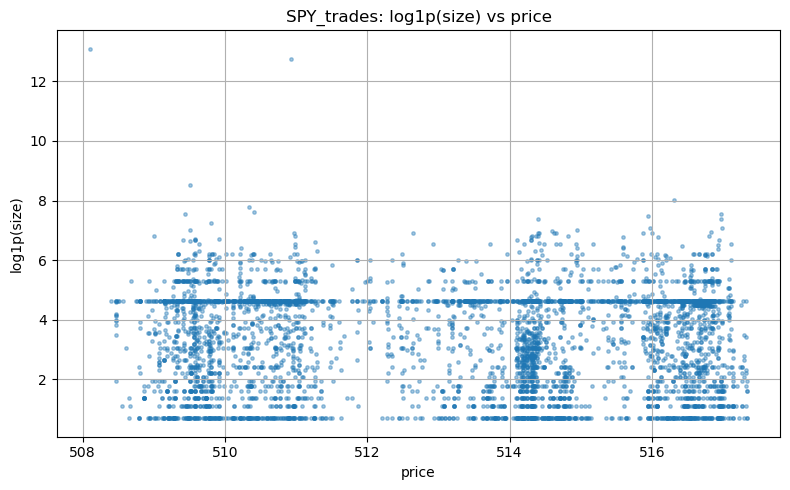

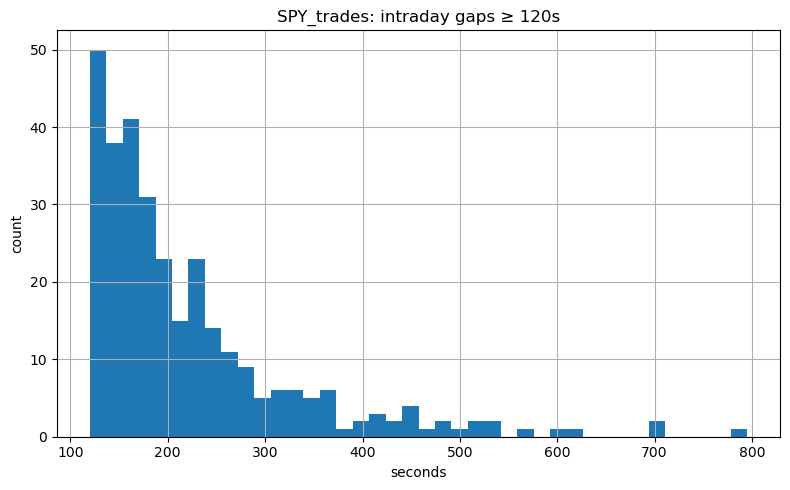

SPY_trades: largest intraday gaps (s) ≥ 120
2024-03-13 13:22:36-04:00  795
2024-03-13 12:44:01-04:00  702
2024-03-13 14:43:01-04:00  702

=== SPY_1s: Pattern Recognition ===


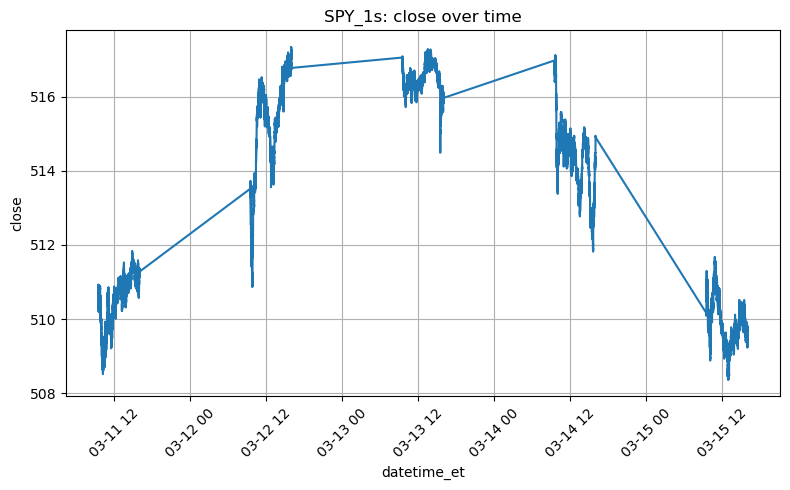

SPY_1s: avg 60-step rolling volatility (pct std) ≈ 0.0000


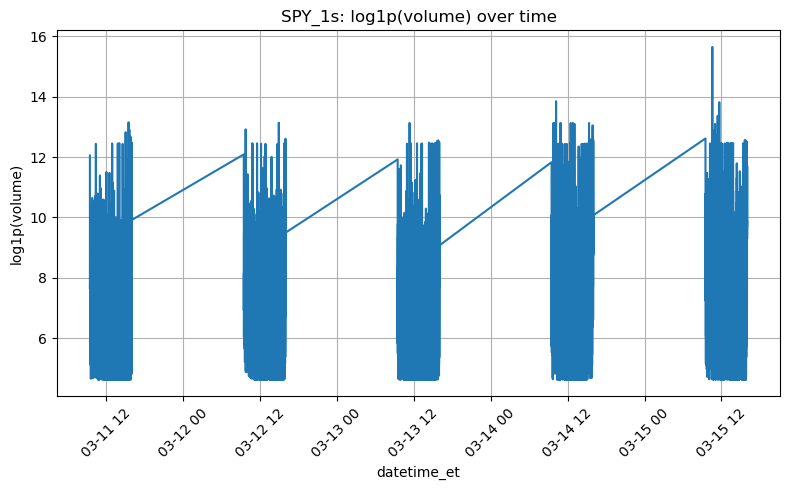

SPY_1s: outliers in volume (IQR) = 9107


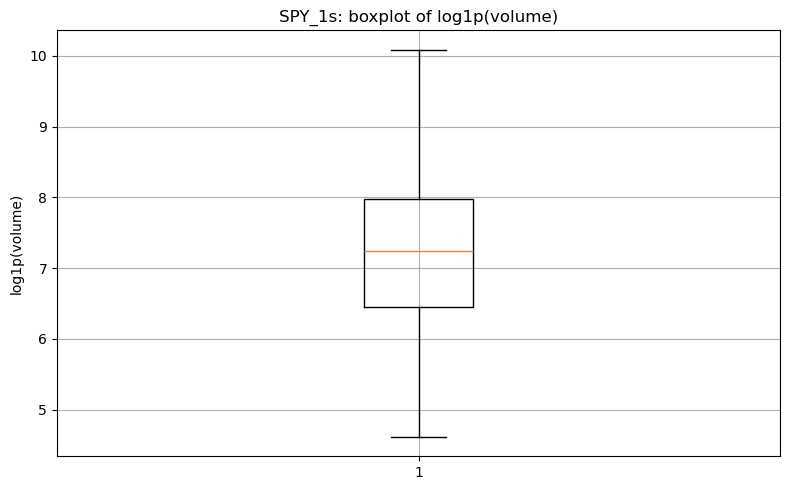

SPY_1s: outliers in transactions (IQR) = 7214


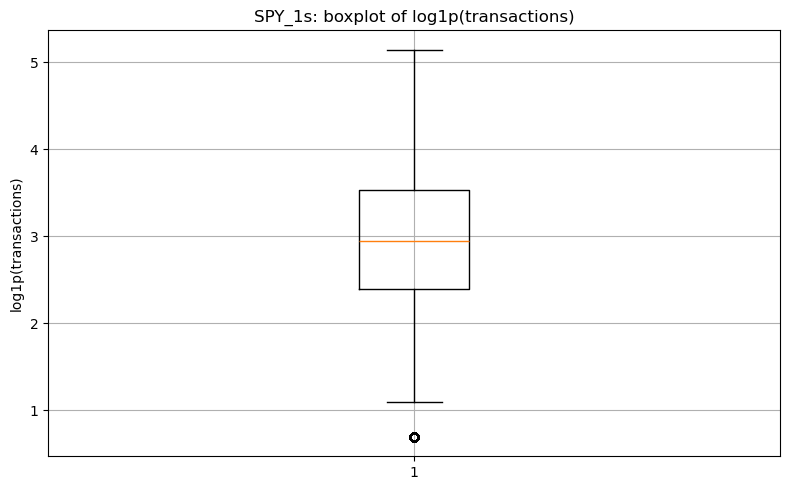

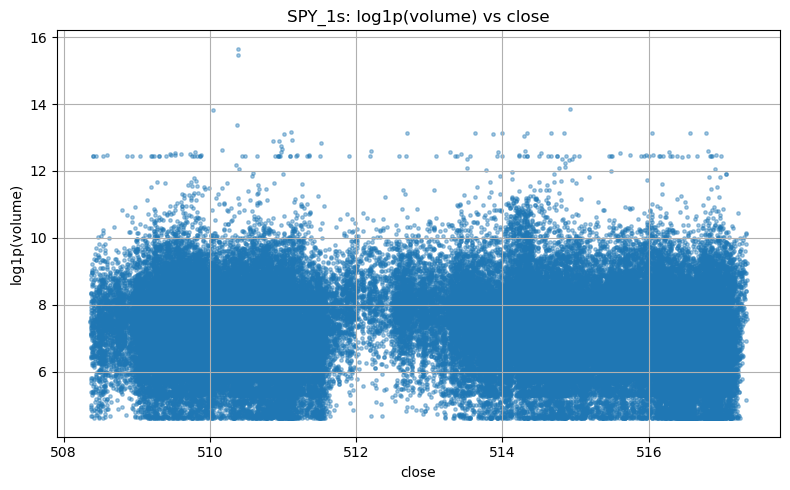


=== SPY_1m: Pattern Recognition ===


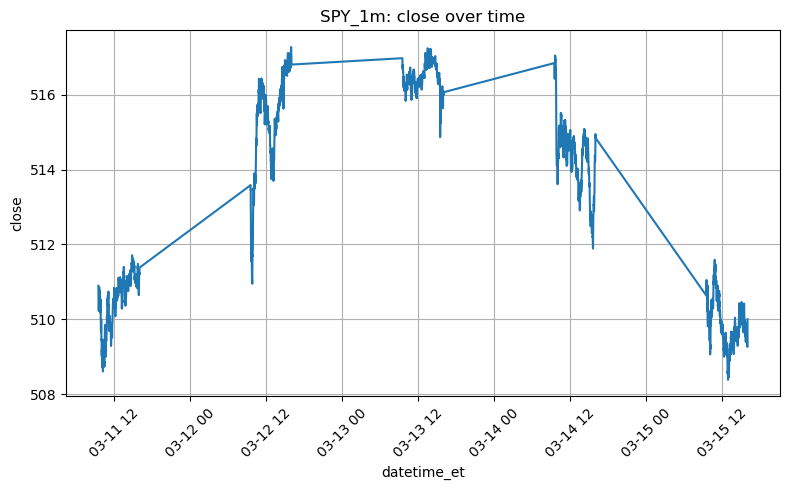

SPY_1m: avg 60-step rolling volatility (pct std) ≈ 0.0003


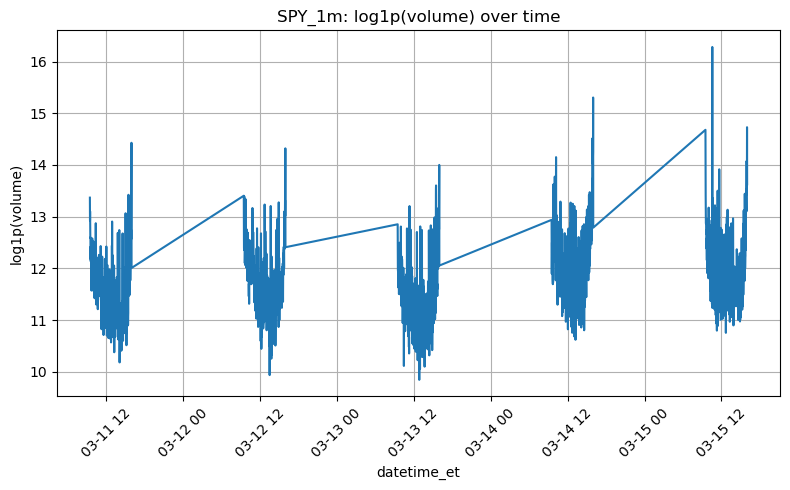

SPY_1m: outliers in volume (IQR) = 156


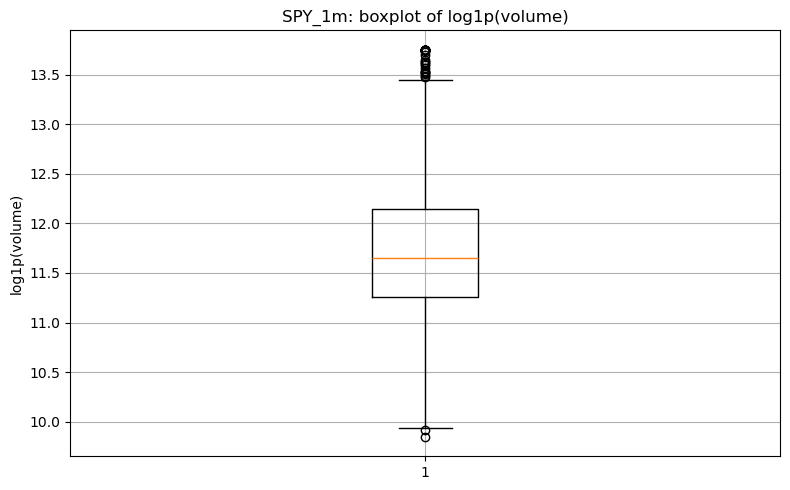

SPY_1m: outliers in transactions (IQR) = 122


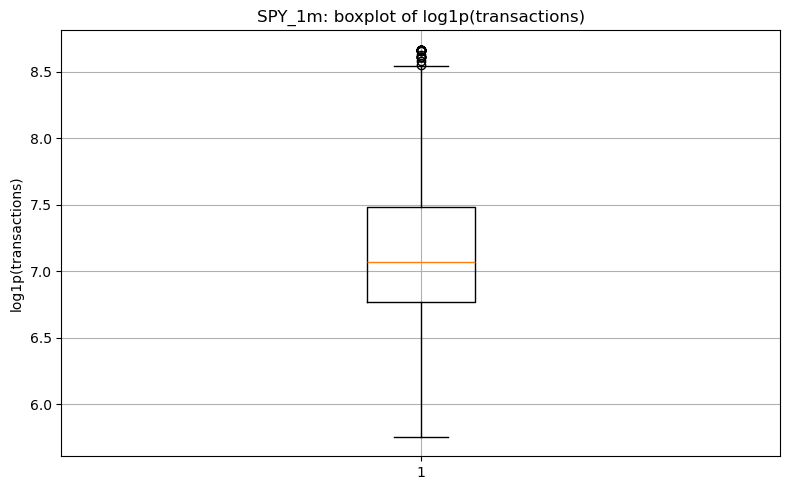

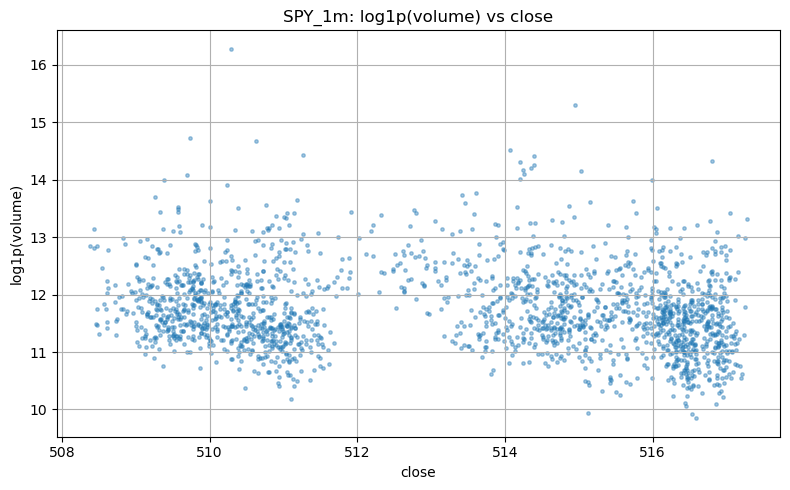


=== OPT_trades: Pattern Recognition ===


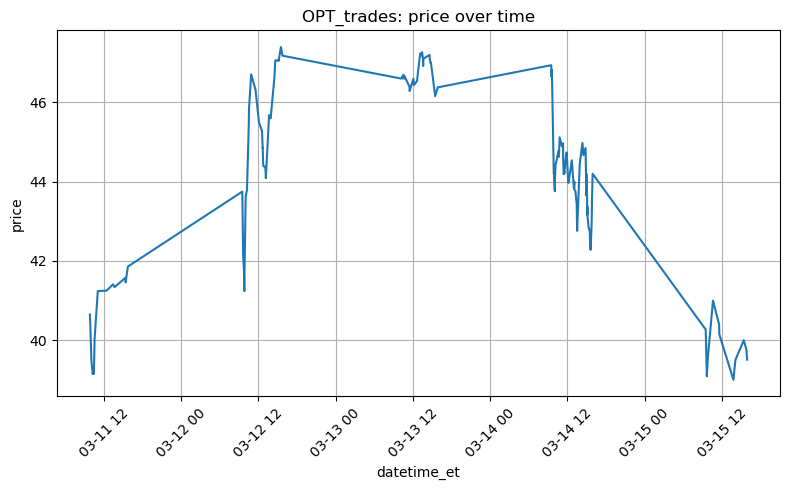

OPT_trades: avg 60-step rolling volatility (pct std) ≈ 0.0097
OPT_trades: outliers in size (IQR) = 42


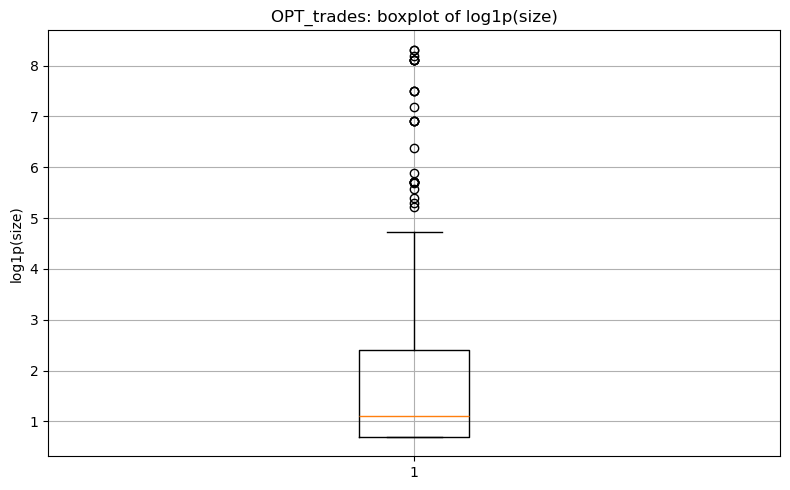

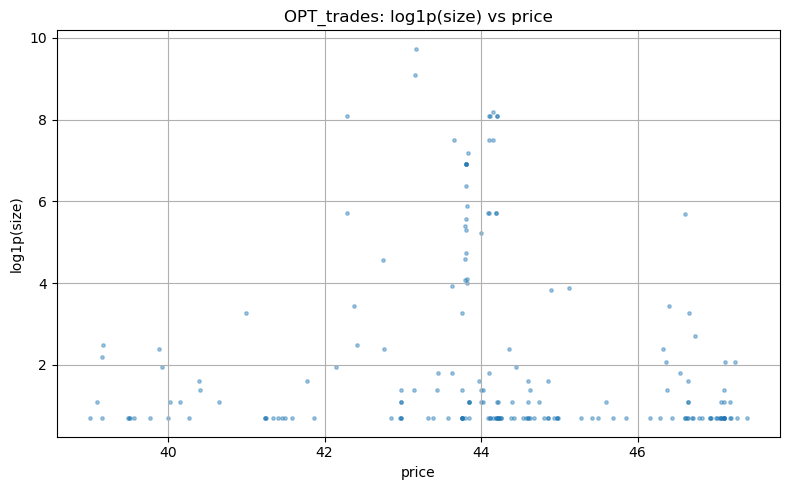

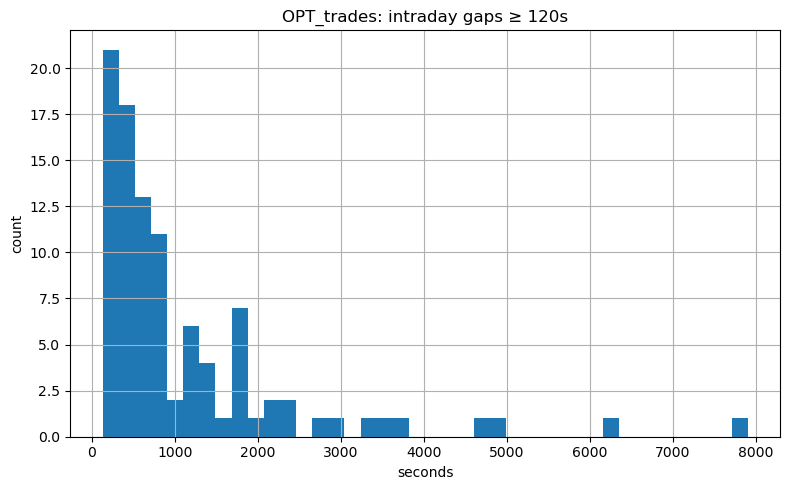

OPT_trades: largest intraday gaps (s) ≥ 120
2024-03-15 13:48:43.394000-04:00  7903
2024-03-11 15:22:06.522000-04:00  6170
2024-03-11 12:24:00.036000-04:00  4880

=== OPT_1s: Pattern Recognition ===


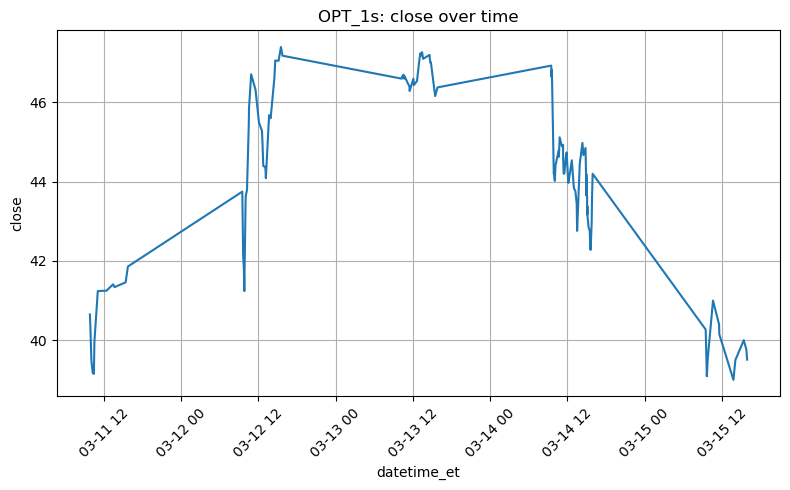

OPT_1s: avg 60-step rolling volatility (pct std) ≈ 0.0130


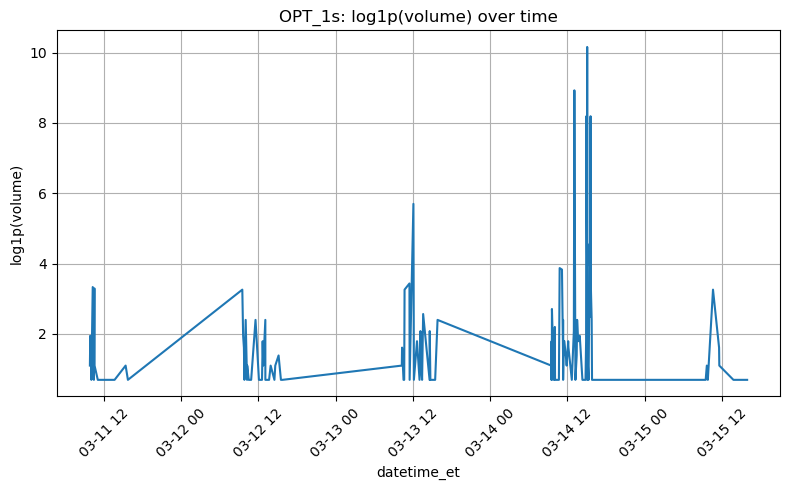

OPT_1s: outliers in volume (IQR) = 23


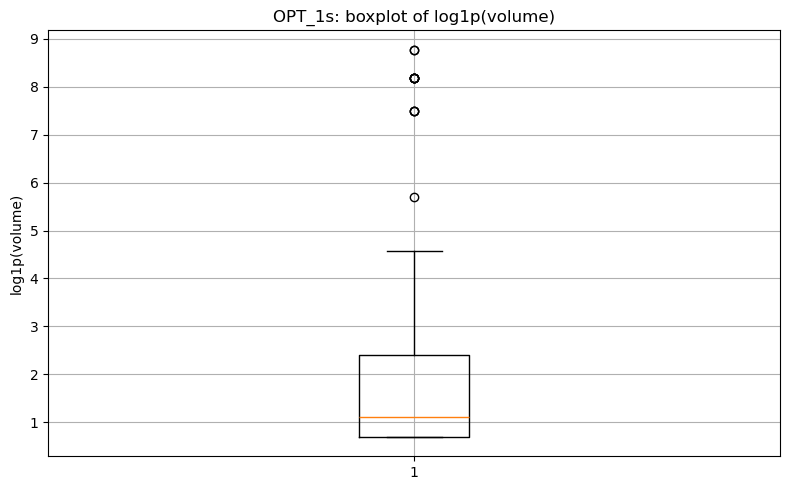

OPT_1s: outliers in transactions (IQR) = 28


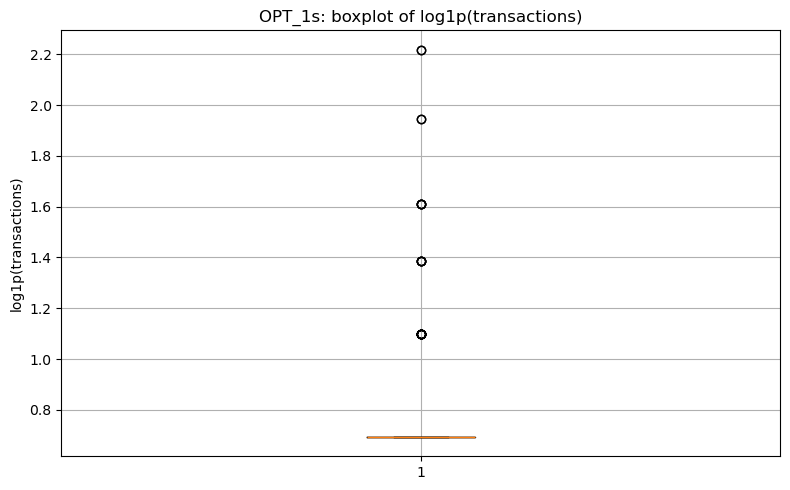

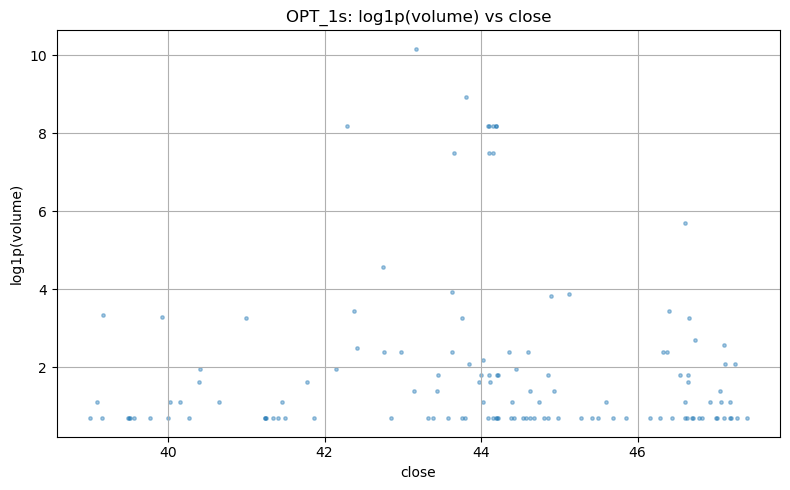

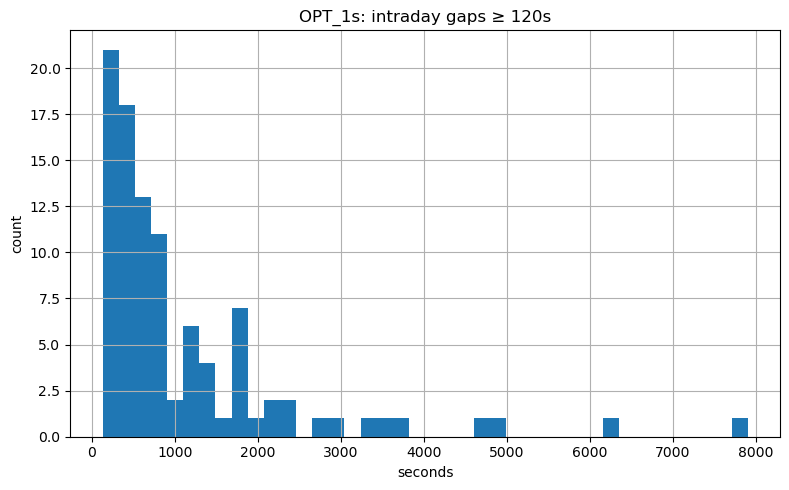

OPT_1s: largest intraday gaps (s) ≥ 120
2024-03-15 13:48:43-04:00  7903
2024-03-11 15:22:06-04:00  6170
2024-03-11 12:24:00-04:00  4880

=== OPT_1m: Pattern Recognition ===


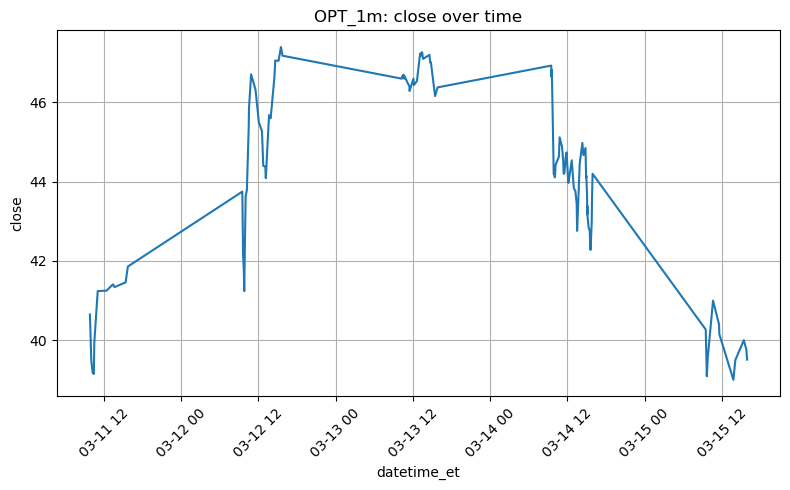

OPT_1m: avg 60-step rolling volatility (pct std) ≈ 0.0137


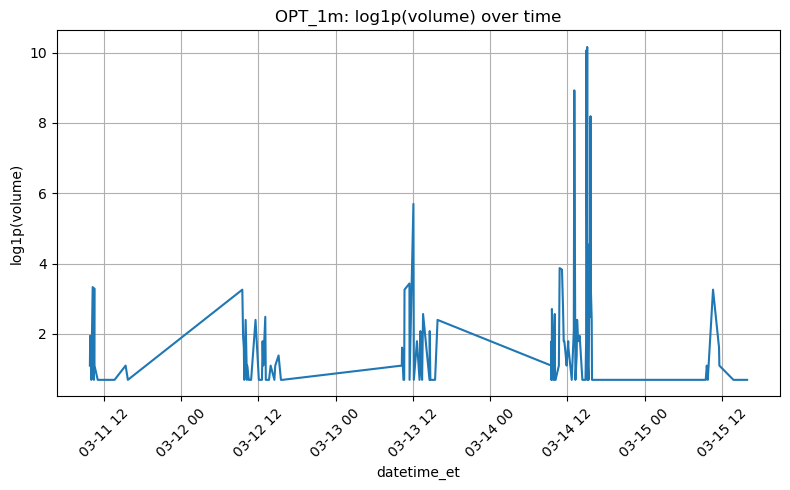

OPT_1m: outliers in volume (IQR) = 16


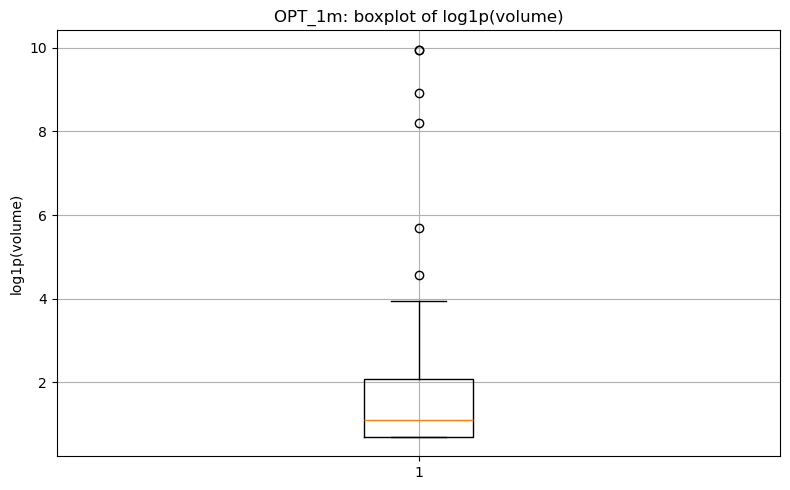

OPT_1m: outliers in transactions (IQR) = 25


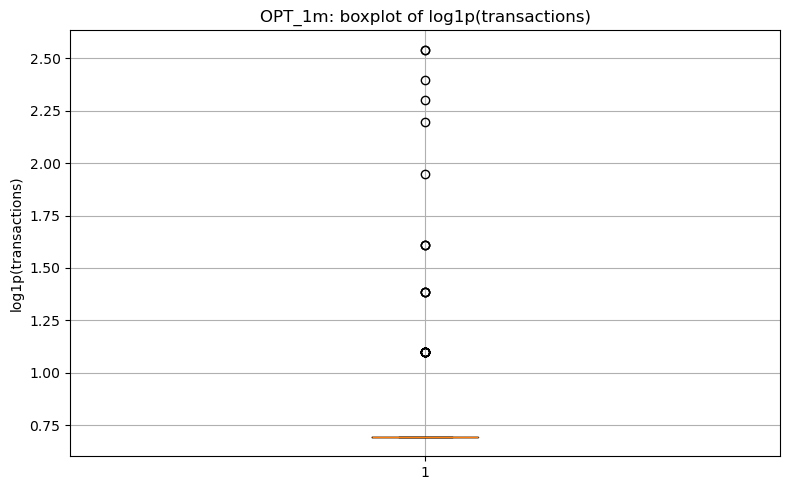

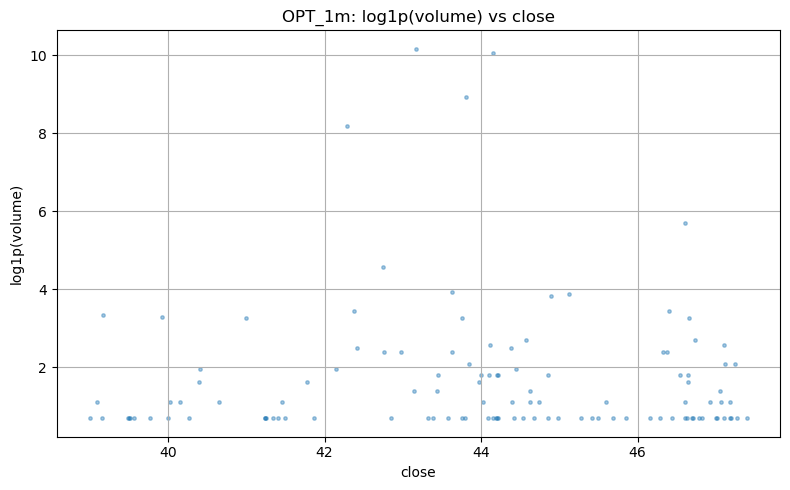

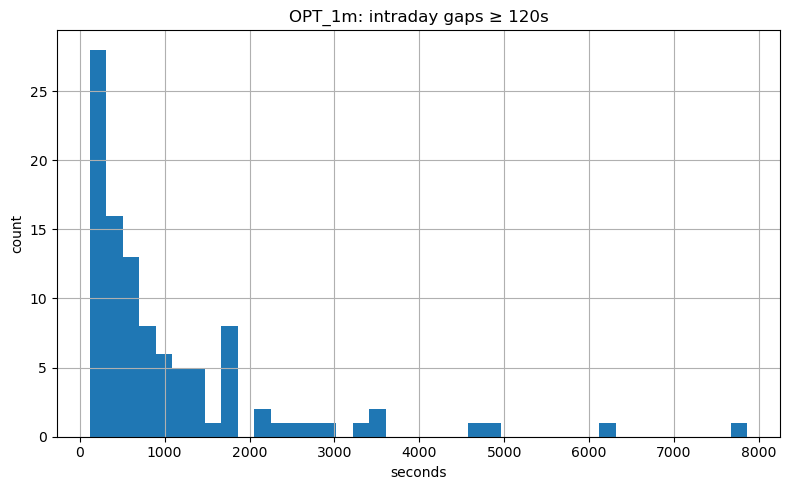

OPT_1m: largest intraday gaps (s) ≥ 120
2024-03-15 13:48:00-04:00  7860
2024-03-11 15:22:00-04:00  6180
2024-03-11 12:24:00-04:00  4920


In [17]:
for name, df in dfs_pat.items():
    run_pattern_recognition(df, name)

## Interpretation Summary

The pattern recognition on SPY and options data from March 11–15, 2024 shows mostly normal but clear trading patterns. Prices go up early in the week and drop back down later, while volume has big spikes around market open and close and one huge one probably from news or algo trades. The outlier check found some really large option trades that look like big investors, not mistakes. The scatter plots show lots of small trades and a few very big ones, and the time gaps mostly look fine except a few longer breaks overnight. Overall the data seems clean and realistic, with trends and outliers that make sense and can be used for more analysis later.